In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords

Init Plugin
Init Graph Optimizer
Init Kernel


[nltk_data] Downloading package punkt to /Users/lizheng/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('all-data.csv', delimiter=',',encoding='latin-1', header = None).rename(columns = {0:"Sentiment", 1:"Message"})
df.head()

,Sentiment,Message
0,neutral,"According to Gran , the company has no plans t..."
1,neutral,Technopolis plans to develop in stages an area...
2,negative,The international electronic industry company ...
3,positive,With the new production plant the company woul...
4,positive,According to the company 's updated strategy f...


In [3]:
df["Message"][0]

'According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .'

In [4]:
df.shape

(4846, 2)

In [5]:
df.index = range(4846)
df['Message'].apply(lambda x: len(x.split(' '))).sum()

111989

In [6]:
sentiment  = {'positive': 0,'neutral': 1,'negative':2} 
df.Sentiment = [sentiment[item] for item in df.Sentiment]

In [7]:
df.head()

,Sentiment,Message
0,1,"According to Gran , the company has no plans t..."
1,1,Technopolis plans to develop in stages an area...
2,2,The international electronic industry company ...
3,0,With the new production plant the company woul...
4,0,According to the company 's updated strategy f...


In [8]:
def print_message(index):
    example = df[df.index == index][['Message', 'Sentiment']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Sentiment:', example[1])

In [9]:
print_message(0)

According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing .
Sentiment: 1


In [10]:
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

In [11]:
train.head(1).index[0]

NameError: name 'train' is not defined

In [12]:
df['Message'] = df['Message'].apply(cleanText)
train, test = train_test_split(df, test_size=0.000001 , random_state=42)

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            #if len(word) < 0:
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens
train_tagged = train.apply(lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.Sentiment]), axis=1)
test_tagged = test.apply(lambda r: TaggedDocument(words=tokenize_text(r['Message']), tags=[r.Sentiment]), axis=1)

# The maximum number of words to be used. (most frequent)
max_fatures = 500000

# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 50

#tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer = Tokenizer(num_words=max_fatures, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Message'].values)
X = tokenizer.texts_to_sequences(df['Message'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Found %s unique tokens.' % len(X))

Found 4846 unique tokens.


In [13]:
test_tagged

3207    ([the, company, was, supposed, to, deliver, ma...
dtype: object

In [14]:
train_tagged

1684    ([unc, charlotte, would, also, deploy, ssh, te...
1044    ([in, 2009, ,, lee, &, man, had, a, combined, ...
4145    ([``, that, 's, a, very, high, figure, on, the...
1538    ([in, finland, ,, the, corresponding, service,...
1034    ([construction, is, scheduled, to, start, in, ...
                              ...                        
4426    ([the, currency, effect, had, a, 3.0, pct, ,, ...
466     ([``, lidskoe, pivo, 's, investment, program, ...
3092    ([products, include, consumer, electronics, de...
3772    ([the, bridge, is, part, of, the, highway, 14,...
860     ([(, adp, news, ), -, oct, 1, ,, 2008, -, finn...
Length: 4845, dtype: object

In [15]:
X.shape

(4846, 50)

In [16]:
d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████████████████████████████| 4845/4845 [00:00<00:00, 2149503.16it/s]


In [17]:
%%time
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

100%|██████████████████████████████████| 4845/4845 [00:00<00:00, 7165515.83it/s]


CPU times: user 3.5 s, sys: 45.1 ms, total: 3.54 s
Wall time: 3.53 s


In [18]:
print(d2v_model)

Doc2Vec(dm/m,d20,n5,w8,s0.001)


In [19]:
len(d2v_model.wv.index_to_key)

11682

In [20]:
embedding_matrix = np.zeros((len(d2v_model.wv.key_to_index) + 1, 20))

# for i, vec in enumerate(d2v_model.wv):
#     # while i <= 3:
#     # print(i)
#     # print(vec)
#     #print(model.docvecs)
#     embedding_matrix[i]=vec
#     if i == 11681:
#         break
#     #print(vec)
#     #print(vec[i])

In [21]:
embedding_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
len(embedding_matrix)

11683

In [23]:
d2v_model.dv

In [24]:
len(d2v_model.dv)

3

In [50]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt
# %matplotlib inline

# def tsne_plot(model):
#     "Creates and TSNE model and plots it"
#     labels = []
#     tokens = []

#     for word in d2v_model.wv.key_to_index:
#         tokens.append(model[word])
#         labels.append(word)
    
#     tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=250, random_state=23)
#     new_values = tsne_model.fit_transform(tokens)

#     x = []
#     y = []
#     for value in new_values:
#         x.append(value[0])
#         y.append(value[1])
        
#     plt.figure(figsize=(16, 16)) 
#     for i in range(len(x)):
#         plt.scatter(x[i],y[i])
#         plt.annotate(labels[i],
#                      xy=(x[i], y[i]),
#                      xytext=(5, 2),
#                      textcoords='offset points',
#                      ha='right',
#                      va='bottom')
#     plt.show()

In [26]:
# tsne_plot(d2v_model)

In [27]:
# word_index = tokenizer.word_index

In [28]:
# word_index

In [29]:
# def get_weight_matrix(model, vocab):
#     # total vocabulary size plus 0 for unknown words
#     vocab_size = len(vocab) + 1
#     # define weight matrix dimensions with all 0
#     weight_matrix = np.zeros((len(d2v_model.wv.key_to_index) + 1, 20))
#     # step vocab, store vectors using the Tokenizer's integer mapping
#     for word, i in vocab.items():
#         weight_matrix[i] = model[word]
#     return weight_matrix

In [30]:
# embedding_vectors = get_weight_matrix(d2v_model, word_index)

In [31]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding

In [32]:
model = Sequential()

# emmbed word vectors
model.add(Embedding(len(d2v_model.wv.key_to_index)+1,20,input_length=X.shape[1], weights=[embedding_matrix], trainable=True))

# learn the correlations
def split_input(sequence):
     return sequence[:-1], tf.reshape(sequence[1:], (-1,1))
model.add(LSTM(50,return_sequences=False))
model.add(Dense(3,activation="softmax"))

# output model skeleton
model.summary()
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=['acc'])

Metal device set to: Apple M1 Pro


2022-02-06 16:58:01.031329: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-02-06 16:58:01.032296: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 20)            233660    
_________________________________________________________________
lstm (LSTM)                  (None, 50)                14200     
_________________________________________________________________
dense (Dense)                (None, 3)                 153       
Total params: 248,013
Trainable params: 248,013
Non-trainable params: 0
_________________________________________________________________


In [33]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [34]:
Y = pd.get_dummies(df['Sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.15, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4119, 50) (4119, 3)
(727, 50) (727, 3)


In [35]:
batch_size = 32
history=model.fit(X_train, Y_train, epochs =50, batch_size=batch_size, verbose = 2)

2022-02-06 16:58:01.565914: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-02-06 16:58:01.568474: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/50


2022-02-06 16:58:01.993156: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-06 16:58:02.151926: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-06 16:58:02.319743: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


129/129 - 4s - loss: 0.5523 - acc: 0.5972
Epoch 2/50
129/129 - 3s - loss: 0.4502 - acc: 0.6686
Epoch 3/50
129/129 - 3s - loss: 0.4636 - acc: 0.6689
Epoch 4/50
129/129 - 3s - loss: 0.4684 - acc: 0.6696
Epoch 5/50
129/129 - 3s - loss: 0.4549 - acc: 0.6858
Epoch 6/50
129/129 - 3s - loss: 0.4563 - acc: 0.6817
Epoch 7/50
129/129 - 3s - loss: 0.4420 - acc: 0.6941
Epoch 8/50
129/129 - 3s - loss: 0.4299 - acc: 0.7050
Epoch 9/50
129/129 - 3s - loss: 0.4129 - acc: 0.7186
Epoch 10/50
129/129 - 3s - loss: 0.4048 - acc: 0.7227
Epoch 11/50
129/129 - 3s - loss: 0.3914 - acc: 0.7342
Epoch 12/50
129/129 - 3s - loss: 0.3830 - acc: 0.7376
Epoch 13/50
129/129 - 3s - loss: 0.3699 - acc: 0.7456
Epoch 14/50
129/129 - 3s - loss: 0.3596 - acc: 0.7519
Epoch 15/50
129/129 - 3s - loss: 0.3541 - acc: 0.7490
Epoch 16/50
129/129 - 3s - loss: 0.3436 - acc: 0.7514
Epoch 17/50
129/129 - 3s - loss: 0.3335 - acc: 0.7618
Epoch 18/50
129/129 - 3s - loss: 0.3213 - acc: 0.7691
Epoch 19/50
129/129 - 3s - loss: 0.3172 - acc: 0

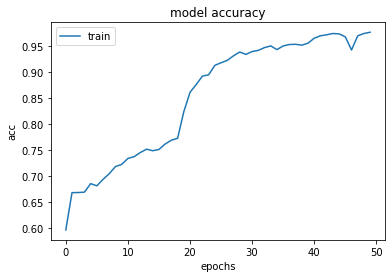

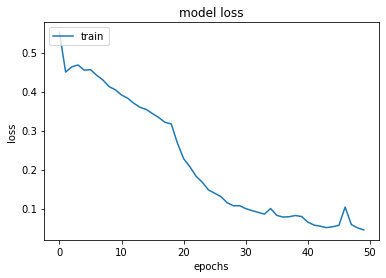

In [36]:
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_accuracy.png')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('model_loss.png')
plt.show()

In [37]:
# evaluate the model
_, train_acc = model.evaluate(X_train, Y_train, verbose=2)
_, test_acc = model.evaluate(X_test, Y_test, verbose=2)
print('Train: %.3f, Test: %.4f' % (train_acc, test_acc))

2022-02-06 17:03:56.313180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-06 17:03:56.358795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


129/129 - 2s - loss: 0.0389 - acc: 0.9820
23/23 - 0s - loss: 1.1288 - acc: 0.6107
Train: 0.982, Test: 0.6107


In [38]:
# predict probabilities for test set
yhat_probs = model.predict(X_test, verbose=0)
print(yhat_probs)
# predict crisp classes for test set
yhat_classes = np.argmax(yhat_probs,axis=1)
print(yhat_classes)
# reduce to 1d array
#yhat_probs = yhat_probs[:, 0]
#yhat_classes = yhat_classes[:, 1

2022-02-06 17:03:59.475882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-02-06 17:03:59.496971: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


[[6.7494409e-03 3.0009817e-02 9.6324068e-01]
 [3.1570043e-08 9.9999988e-01 6.5220107e-08]
 [1.0887172e-01 8.7161779e-01 1.9510495e-02]
 ...
 [5.4207698e-07 9.9999726e-01 2.2188510e-06]
 [8.6013266e-08 9.9999988e-01 1.6164933e-08]
 [8.7576556e-01 7.6549599e-04 1.2346894e-01]]
[2 1 1 1 1 1 2 2 0 1 1 0 1 1 1 1 1 2 0 1 2 1 1 1 1 1 0 1 1 1 1 1 1 2 1 1 0
 0 1 1 0 1 1 0 0 2 1 1 2 1 1 0 0 2 1 1 1 1 1 1 2 0 2 1 2 1 0 0 1 2 1 0 2 1
 1 1 1 0 1 0 1 2 1 2 0 0 2 2 2 0 0 1 1 2 0 1 2 1 1 1 2 1 1 1 1 2 2 1 2 1 1
 0 2 1 1 1 1 1 0 0 2 1 1 1 0 1 2 2 0 0 1 0 0 1 0 0 0 1 0 0 1 1 2 2 1 2 1 1
 0 1 1 2 0 1 1 2 1 0 2 2 1 1 1 1 1 0 0 1 0 1 1 0 1 2 0 0 1 1 0 0 0 0 1 1 1
 2 0 0 1 1 1 0 0 1 1 2 1 0 2 0 1 1 2 0 1 1 1 1 1 2 1 1 0 1 0 1 1 2 0 1 0 0
 1 0 1 1 2 0 0 1 1 1 2 0 1 2 1 0 2 1 0 1 1 1 1 0 2 2 2 0 1 1 0 0 2 0 1 1 0
 1 1 0 1 0 2 1 0 0 1 1 1 2 0 1 2 1 1 1 1 1 0 1 1 2 1 1 0 1 0 2 1 1 2 1 0 1
 0 2 2 1 0 1 1 1 1 1 1 0 1 0 1 2 0 1 1 1 0 1 2 1 2 1 2 1 0 1 1 0 1 1 1 0 0
 0 0 1 0 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 1 0 2 

In [39]:
import numpy as np
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels

array([1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 2, 2, 1,
       0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 2, 1, 0, 2, 1, 1, 2, 0, 1, 1, 1,
       0, 2, 0, 1, 0, 1, 1, 1, 0, 2, 1, 0, 1, 1, 1, 1, 0, 0, 2, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 2, 0, 2, 0, 0, 1, 0,
       1, 0, 0, 1, 2, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 2,
       1, 0, 2, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 2, 1, 0, 1, 2, 0,
       1, 1, 0, 1, 0, 2, 0, 1, 1, 1, 2, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 1, 1, 0, 2, 2, 0, 0, 1, 0, 1, 0, 1, 2, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 0, 2, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,
       1, 0, 1, 1, 0, 2, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       2, 1, 2, 1, 1, 0, 1, 1, 2, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 2, 1, 1,
       0, 1, 2, 1, 0, 1, 0, 2, 2, 1, 1, 1, 0, 0, 0,

In [40]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
cm

array([[105,  78,  33],
       [ 88, 293,  46],
       [ 18,  20,  46]])

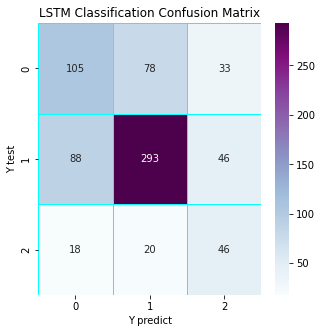

In [41]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

lstm_val = confusion_matrix(rounded_labels, yhat_classes)
f, ax = plt.subplots(figsize=(5,5))
sns.heatmap(lstm_val, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Y predict')
plt.ylabel('Y test')
plt.show()

## Validation

In [42]:
validation_size = 610

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 1, batch_size = batch_size)

print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

4/4 [==============================] - 0s 38ms/step - loss: 1.1098 - acc: 0.6325
score: 1.11
acc: 0.63


In [43]:
model.save('Mymodel.h5')

In [44]:
message = ['Congratulations! you have won a $1,000 Walmart gift card']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[0.83215356 0.03914655 0.12869988]] 0


In [45]:
message = ['such massive asteroid hit will certainly create new business opportunities']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[9.9962038e-01 1.5272305e-04 2.2686634e-04]] 0


In [46]:
message = ['so does anyone else not open Snapchat anymore ? or is it just me ... ugh this so sad.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[2.5933597e-04 9.9891412e-01 8.2650164e-04]] 1


In [47]:
message = ['@elonmusk had a terrible experience with a very pushy sales guy from tesla Stanford shop while shopping for model x']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[0.01778973 0.5879715  0.39423886]] 1


In [48]:
message = ['The local electronics industry is expected to remain stable amid layoff concerns surrounding Japanese electronics giants operating in the country, an official says.']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])

[[3.5030535e-08 9.9999976e-01 1.5296010e-07]] 1


In [49]:
message = ['The local electronics industry is amid layoff concerns and last year has laid off tens of employees']
seq = tokenizer.texts_to_sequences(message)

padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

pred = model.predict(padded)

labels = ['0','1','2']
print(pred, labels[np.argmax(pred)])


[[0.01068473 0.00320531 0.98610985]] 2
